In [2]:

%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse
import pylib.Chebyschev_coefs as ch
colors_ = ["blue", "red", "green", "gray", "black"]
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
path_save_ = "./jupyter-notebooks/NL/results/"

17759
/media/work/docs/codes/QuCF/scripts-py


In [3]:
for i in range(30):
    plt.close()

In [4]:
# -----------------------------------------------------------
# --- LCHS parameters ---
# -----------------------------------------------------------
mix.reload_module(mix)
def compute_k_grid_angles():
    alpha_k0 = - 1.0
    alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)

    print("nk \t\t{:d}".format(nk_))
    print("alpha_k0 \t{:0.12e}".format(alpha_k0))
    print("alpha_k1 \t{:0.12e}".format(alpha_k1))
    return
# -------------------------------------------------------------------

k_max_, nk_ = 40.967741935484, 7  # dk = 6.452e-01
# k_max_, nk_ = 10.0, 7             # dk = 1.575e-01
# k_max_, nk_ = 20.079, 8           # dk = 1.575e-01


Nk_ = 1 << nk_
k_grid_ = np.linspace(-k_max_, k_max_, Nk_)
dk_ = np.diff(k_grid_)[0]

print("nk:\t {:d}".format(nk_))
print("kmax:\t {:0.12f}".format(k_max_))
print("dk:\t {:0.12e}".format(dk_))

print("\n--- BE angles for for the chosen k-grid ---")
compute_k_grid_angles() 

nk:	 7
kmax:	 40.967741935484
dk:	 6.451612903226e-01

--- BE angles for for the chosen k-grid ---
nk 		7
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.007874015748e+00


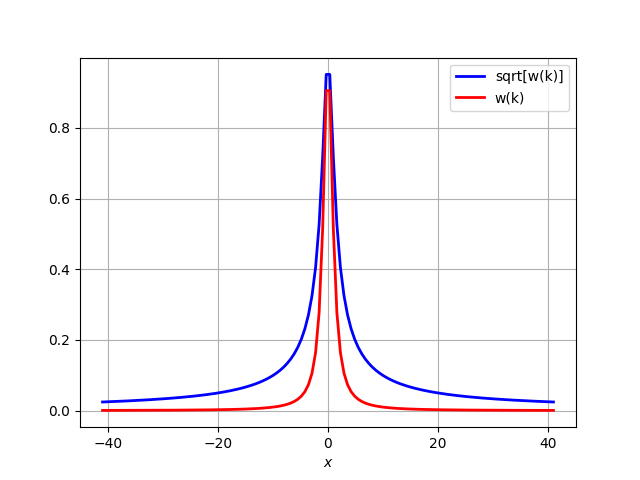

In [11]:
# -------------------------------------------------------------------
# --- Plot weights --- 
# -------------------------------------------------------------------
mix.reload_module(mix)

def func_sqrt_weights(k):
    return np.sqrt(1./ (1 + k**2))

def func_weights(k):
    return 1./ (1 + k**2)

def plot_weights(flag_save):

    # --- Plotting ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        k_grid_, func_sqrt_weights(k_grid_), 
        color='b', linewidth = 2, linestyle='-',  label = "sqrt[w(k)]"
    )
    ax.plot(
        k_grid_, func_weights(k_grid_), 
        color='r', linewidth = 2, linestyle='-',  label = "w(k)"
    )
    plt.xlabel('$x$')
    ax.legend()
    plt.grid(True)
    plt.show()
    
    # --- Save the data ---
    if flag_save:
        fname = "weights_profs_k{:d}.dat".format(k_max_)
        full_name = path_save_ + "/" + fname
        mix.save_dat_plot_1d_file(full_name, k_grid_, func_weights(k_grid_))
        
        fname = "weights_sqrt_profs_k{:d}.dat".format(k_max_)
        full_name = path_save_ + "/" + fname
        mix.save_dat_plot_1d_file(full_name, k_grid_, func_sqrt_weights(k_grid_))
    
    return
# ------------------------------------------------------------
plot_weights(flag_save = False)

Function parameter:		 4.097e+01
Chosen function, parity:	 LCHS-weights, 0

max. |norm y|: 9.898e-01


Minimization method is used.
Computation status:  6.924892534496654e-11

Chosen polynomial's degree:	 800
Number of coefficients:		 400
max. abs. error: 3.791e-06


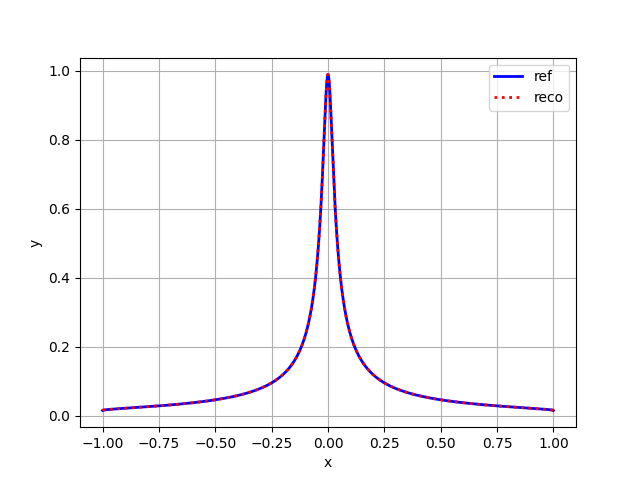

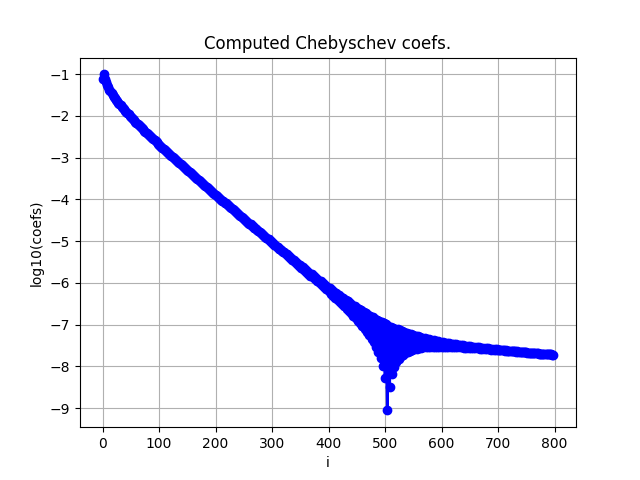

In [8]:
# -----------------------------------------------------------
# --- Compute QSVT angles for the LCHS weights ---
# -----------------------------------------------------------
mix.reload_module(ch)

def compute_QSVT_angles(flag_save):
    # --- Choose the computational method ---
    sel_method = 0

    # --- Choose the function to approximate ---
    id_fun = 4 # chosen function;
    par1   = 40.968 # function parameter;

    # --- Choose the polynomial degree ---
    Nd = 800

    # --- Computation ---
    oo_ch_ = ch.Ch_()
    oo_ch_.choose_method(sel_method)
    oo_ch_.choose_func(id_fun, par1)
    oo_ch_.compute_Ch(Nd)
    oo_ch_.plot_reconstructed_function()
    oo_ch_.plot_coefficients()
    if flag_save:
        oo_ch_.save_coefficients()
    return
# --------------------------------------------------------
compute_QSVT_angles(flag_save = False)

In [70]:
# ---------------------------------------------------------------------------------------
# --- Scaling of the number of Chebyschev coefficients necessary to implement weights ---
# --- with the desired precision for the chosen kmax.                                 ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)

def scaling_success_probability():
    def save_data(kmax, ss_prob):
        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_weights_ss_prob.dat", 
            kmax, 
            ss_prob
        )
        return
    # -------------------------------------------------------------------------

    kmax_s  = [10,        20,        30,        40,        50,        60]
    ss_prob = [3.745e-01, 2.701e-01, 2.240e-01, 1.945e-01, 1.743e-01, 1.593e-01]
    ss_prob = np.array(ss_prob)**2
    save_data(kmax_s, ss_prob)
    return
# --------------------------------------------------------------------------
def scaling_Nd_eps():
    def save_data_eps(Nd, eps, kmax_in):
        N_angles = 2 * (np.array(Nd)/2) - 1
        log_eps = -np.log10(eps) 

        mix.save_dat_plot_1d_file(
            path_save_ + "/scan_Na_eps_kmax{:d}.dat".format(kmax_in), 
            log_eps, 
            N_angles
        )
        return

    def get_data_eps(Nd, eps):
        N_angles = 2 * (np.array(Nd)/2) - 1
        log_eps = np.log10(eps) 
        return N_angles, log_eps
    # -------------------------------------------------------------------------

    kmax_s = 10
    abs_errors = [2.378e-3, 1.512e-04, 1.178e-04, 6.447e-05, 4.188e-05, 2.514e-05, 1.120e-05]
    Nd_pol     = [      50,       120,       150,       250,       350,       500,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 20
    abs_errors = [2.242e-03, 1.555e-04,  2.575e-05, 1.479e-05, 1.263e-05, 5.628e-06]
    Nd_pol     = [      100,       150,        300,       450,       500,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 40
    abs_errors = [2.185e-03, 1.507e-04, 1.085e-05, 4.793e-06, 3.541e-06, 2.817e-06]
    Nd_pol     = [      200,       300,       400,       600,       800,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 60
    abs_errors = [2.165e-03, 1.495e-04, 1.079e-05, 2.361e-06, 1.878e-06]
    Nd_pol     = [      300,       450,       600,       800,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)


    kmax_s = 80
    abs_errors = [2.156e-03, 1.489e-04, 1.075e-05, 1.405e-06]
    Nd_pol     = [      400,       600,       800,      1000]
    save_data_eps(Nd_pol, abs_errors, kmax_s)
    
    return
# --------------------------------------------------------------------------
scaling_success_probability()
scaling_Nd_eps()

write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax10.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax20.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax40.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax60.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax80.dat


Reading the file ../QuCF/simulations/LCHS/KvN/test-weights//weights_OUTPUT.hdf5...
Name of the simulation is weights
Simulation has been performed  07-11-2024 11:50:22


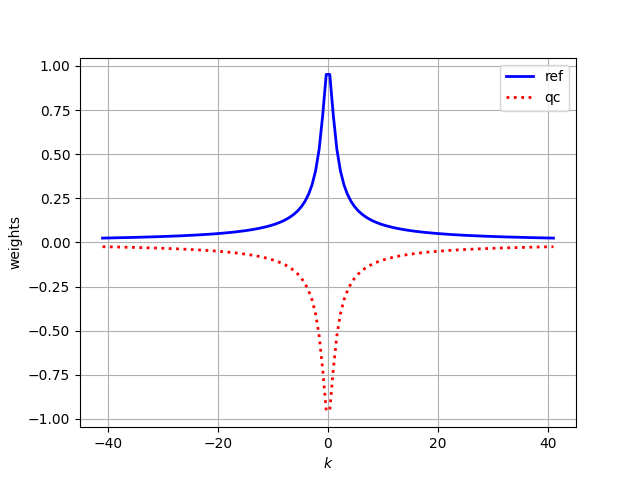


A-max (before renorm.): 4.253467948816e-01
success prob. (before renorm.): 9.575494186643e-01

N-gates: 965


In [23]:
# -----------------------------------------------------------------
# --- QuCF computation of the LCHS weights ---
# -----------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)

# ----------------------------------------------------------------------
# --- QuCF computation of the LCHS weights computed by QSVT ---
def QuCF_QSVT_weights(kmax, nk, flag_AA):
    Nk = 1 << nk
    k = np.linspace(-kmax, kmax, Nk)
    dk = np.diff(k)[0]

    y_ref = np.sqrt(1./(1 + k**2))

    # --- QuCF data ---
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/simulations/LCHS/weights-AA/"
    om.pname_ = "AA"
    om.open()
    om.set_zero_ancillae_work_states(0)
    om.read_qsvt()

    # --- qucf signal ---
    coef_norm = 2**(nk/2.) * 1./om.dd_["weights"]["rescaling_factor"]
    y_qc = om.get_var_x({}, "rk") 
    succ_prob = np.sum(np.abs(y_qc)**2)

    # --- Renormalization of the QC signal ---
    y_qc = y_qc.real

    if not flag_AA:
        # for non-amplified signal:
        y_qc *= -1.
        y_qc *= coef_norm
    else:
        # for amplified signal:
        y_qc *= -1.  # the sign varies !!!
        y_qc = y_qc/np.max(np.abs(y_qc)) * np.max(y_ref)

    # --- Plotting results ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k, y_ref, '-b', linewidth = 2, label = "ref")
    ax.plot(k, y_qc,  ':r', linewidth = 2, label = "qc")
    plt.xlabel('$k$')
    plt.ylabel("weights")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Compute the maximum amplitude ---
    y_qc_norm = om.get_var_x({}, "rk")

    # --- Print some results ---
    print("success probability: {:0.12e}".format(succ_prob))
    print("A_max = {:0.12e}".format(np.max(np.abs(y_qc_norm))))
    return
# ----------------------------------------------------------------------
# --- QuCF computation of the LCHS weights computed by QSVT ---
# ----------------------------------------------------------------------
def QuCF_direct(kmax, nk, flag_AA):
    Nk = 1 << nk
    k = np.linspace(-kmax, kmax, Nk)
    dk = np.diff(k)[0]
    y_ref = np.sqrt(1./(1 + k**2))

    Hadamart_norm_factor = 2**(nk/2)

    # --- QuCF data ---
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/simulations/LCHS/KvN/test-weights/"
    om.pname_ = "weights"
    om.open()
    Ngates = om.dd_["N-gates"]

    om.set_zero_ancillae_work_states(0)
    y_qc = om.get_var_x({}, "rk")

    succ_prob = np.sum(np.abs(y_qc)**2)
    max_ampl = np.max(np.abs(y_qc))

    # --- renormalization ---
    y_qc = y_qc.real
    if not flag_AA:
        y_qc *= Hadamart_norm_factor
    else:
        y_qc = y_qc/np.max(np.abs(y_qc)) * np.max(y_ref)

    # --- Plotting results ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(k, y_ref, '-b', linewidth = 2, label = "ref")
    ax.plot(k, y_qc,  ':r', linewidth = 2, label = "qc")
    plt.xlabel('$k$')
    plt.ylabel("weights")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Print some resulting parameters ---
    print()
    print("A-max (before renorm.): {:0.12e}".format(max_ampl))
    print("success prob. (before renorm.): {:0.12e}".format(succ_prob))
    print()
    print("N-gates: {:d}".format(Ngates))
    return
# ----------------------------------------------------------------------
# nk, kmax = 5, 10
# nk, kmax = 8, 100
# nk, kmax = 9, 100
# nk, kmax = 7, 40.968
# nk, kmax = 7, 10.
# nk, kmax = 8, 20.079

# QuCF_QSVT_weights(k_max_, nk_, flag_AA = True)

QuCF_direct(k_max_, nk_, flag_AA = True)

In [26]:
# ----------------------------------------------------------
# --- Amplitude amplification of sqrt(weights) ---
# ----------------------------------------------------------
def print_rr(line_str, A_ampl, A_non_ampl):
    rr = A_ampl / A_non_ampl
    print("{:s}:\t rr = {:0.12e}".format(line_str, rr))
    return
# ---------------------------------------
# *** Here, succ_prob is a non-amplified success probability. ***
def print_NA(line_str, succ_prob):
    theta_AA = np.arcsin(np.sqrt(succ_prob))
    N_AA = int(0.5 * (np.pi/(2.*theta_AA) - 1.))  # +/- 1
    print("{:s}:\t N_AA {:d}".format(line_str, N_AA))
    return
# -----------------------------------------
def copmute_AA_QSVT():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 10,      nk = 5", 4.156002297806e-01, 1.682383322842e-01)
    print_rr("kmax = 40.968,  nk = 7", 4.240889334557e-01, 8.328414714733e-02)
    print_rr("kmax = 100,     nk = 8", 4.565726282533e-01, 5.760944577155e-02)
    print_rr("kmax = 10,      nk = 7", 2.132800803959e-01, 8.811472985557e-02)
    print_rr("kmax = 20.079,  nk = 8", 2.222691714695e-01, 6.168556215840e-02)

    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print()
    print_NA("kmax = 10,      nk = 5", 1.428e-01)
    print_NA("kmax = 40.968,  nk = 7", 3.670864726304e-02)
    print_NA("kmax = 100,     nk = 8", 1.523e-02)
    print_NA("kmax = 10,      nk = 7", 1.460374767831e-01)
    print_NA("kmax = 20.079,  nk = 8", 7.424705768981e-02)
    return
# -----------------------------------------
def copmute_AA_Dir():
    # --- Compute the ration between amplified and non-amplified signals ---
    print_rr("kmax = 40.968,  nk = 7", 4.253467948816e-01, 8.411995216652e-02)

    # --- Compute the number of repetitions of the AA operator: +/- 1 ---
    print_NA("kmax = 40.968,  nk = 7", 3.745181779427e-02)
    return
# -----------------------------------------
print("REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.\n")
# copmute_AA_QSVT()
copmute_AA_Dir()

REMARK: the value rr**2 is used for the renormalization of LCHS results computed with amplified weights.

kmax = 40.968,  nk = 7:	 rr = 5.056431725491e+00
kmax = 40.968,  nk = 7:	 N_AA 3


In [ ]:
# ---------------------------------------------------------
# --- Compute correcting angles for the sqrt(weights) ---
# ---------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)
from scipy.optimize import fsolve

def compute_BE_angles(kmax, nk):
    def compute_corr():
        # !!! Attention !!!
        # the correction angles is computed from a QuCF computation performed
        # without the correcting gates:

        om = mse.MeasOracle__(True)
        om.path_ = "../QuCF/tests/compute-weights/"
        om.pname_ = "weights"
        om.open()
        om.set_work_states(0)
        res_k0 = om.get_var_x({"a_be": 0, "rk": 0}, "a_qsvt") 

        def func_to_solve(x):
            aa = res_k0[0]
            aas = res_k0[1]
            return [aa * np.cos(x[0]/2.) - 1j*np.sin(x[0]/2.)*aas - aa / np.sqrt(2.)]

        res = fsolve(func_to_solve, [0.1])

        print("recheck: {:20.3e}".format(func_to_solve(res)[0]))
        print()

        return res[0] 
    # -------------------------------------------------------
    Nk = 1 << nk
    alpha_k_corr = compute_corr()
    print("alpha_k_corr \t{:0.12e}".format(alpha_k_corr))

    del alpha_k0, alpha_k1
# ------------------------------------------------------------------------------------
compute_BE_angles(
    kmax = 10,
    nk = 14
)